# Tracking test
Perform test for the neuron tracking (identities).  
Inputs are RGB and binary detection frames, and the tracker outputs frames similar to the binary segmentation with a different values for each neuron identity. I.e., 0 is background, 1 is for the pixel of the same neuron through time, 2 is for another neuron, etc.

In [1]:
%matplotlib inline

import os, time, sys
from importlib import reload
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
from skimage import io, measure
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import cluster, mixture, decomposition

from utils_common.image import to_npint, imread_to_float
from utils_common.register_cc import register_stack, shift_image
from internal_model import InternalModel

%load_ext autoreload
%autoreload 2

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

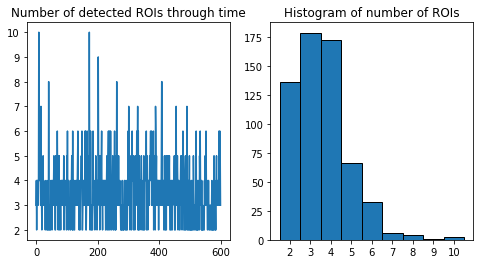

In [2]:
exp = "/data/talabot/pdm/dataset_cv-annotated/train/MAN-1_image_MAN1_tdTom-GC6s_009/"

rgb_stack = imread_to_float(os.path.join(exp, "RGB.tif"))
seg_stack = io.imread(os.path.join(exp, "seg_ROI.tif")).astype(np.bool)
if os.path.isfile(os.path.join(exp, "lbl_ROI.tif")):
    lbl_stack = io.imread(os.path.join(exp, "lbl_ROI.tif"))
else:
    lbl_stack = None

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])
# Display for visualization
reload(plt)
%matplotlib inline
@interact(image = (0, len(rgb_stack) - 1))
def plot_data(image=0):
    labels = measure.label(seg_stack[image], connectivity=1)
    regions = measure.regionprops(labels)
    centroids = np.array([region.centroid for region in regions])
    areas = np.array([region.area for region in regions])
#     seg_CoM = (centroids * areas[:,np.newaxis]).sum(0) / areas.sum()
    seg_CoM = centroids.mean(0)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("RGB")
    plt.imshow(rgb_stack[image])
    plt.plot(seg_CoM[1], seg_CoM[0], 'wx')
    plt.subplot(132)
    plt.title("Segmentation")
    plt.imshow(seg_stack[image], cmap="gray")
    plt.plot(seg_CoM[1], seg_CoM[0], 'rx')
    if lbl_stack is not None:
        plt.subplot(133)
        plt.title("Labels")
        plt.imshow(lbl_stack[image], cmap=id_cmap, vmin=1)
        plt.plot(seg_CoM[1], seg_CoM[0], 'wx')
    plt.show()

# Plot number of detected ROIs along time
num_roi = np.zeros(len(seg_stack))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(seg_stack[i], connectivity=1, return_num=True)[1]

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

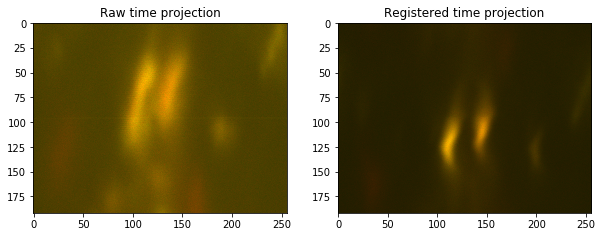

In [3]:
ref_id = 1 # reference frame for registration and number of clusters

# Compute registration through cross-correlation
reg_seg, reg_rows, reg_cols = register_stack(seg_stack, ref_num=ref_id, return_shifts=True)
reg_rgb = np.zeros_like(rgb_stack)
for i in range(len(rgb_stack)):
    reg_rgb[i] = shift_image(rgb_stack[i], reg_rows[i], reg_cols[i])
reg_seg = reg_seg.clip(0, 1)
reg_rgb = reg_rgb.clip(0, 1)
    
# Reference centroids (possibly weighted by area)
labels = measure.label(seg_stack[ref_id], connectivity=1)
regions = measure.regionprops(labels)
centroids = np.array([region.centroid for region in regions])
areas = np.array([region.area for region in regions])
ref_CoM = (centroids * areas[:,np.newaxis]).sum(0) / areas.sum()
# ref_CoM = centroids.mean(0)

reload(plt)
%matplotlib inline
@interact(image = (0, len(rgb_stack) - 1))
def plot_data(image=0):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("Registered input")
    plt.imshow(reg_rgb[image])
    plt.plot(ref_CoM[1], ref_CoM[0], 'wx')
    plt.subplot(122)
    plt.title("Registered binary detection")
    plt.imshow(reg_seg[image], cmap='gray')
    plt.plot(ref_CoM[1], ref_CoM[0], 'rx')
    plt.show()
    
rgb_mean = rgb_stack.mean(0)
rgb_mean /= rgb_mean.max()
reg_rgb_mean = reg_rgb.mean(0)
reg_rgb_mean /= reg_rgb_mean.max()

reload(plt)
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Raw time projection")
plt.imshow(rgb_mean)
plt.subplot(122)
plt.title("Registered time projection")
plt.imshow(reg_rgb_mean)
plt.show()

## Clustering tracker
Cluster neurons of each frames into a feature space, and regroup them there.

### Approximation of outliers
Try to find how many frames are far different because of e.g. motions, (dis-)appearing neurons, etc.

## Internal model

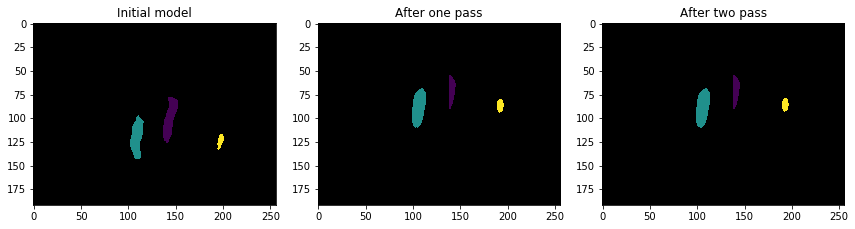

In [4]:
model = InternalModel()
identities = np.zeros(seg_stack.shape, np.uint8)
plt.figure(figsize=(12,4))

# Initialization on the first frame
identities[0] = measure.label(seg_stack[0], connectivity=1)
model.initialize(rgb_stack[0], identities[0])
plt.subplot(131)
plt.title("Initial model")
plt.imshow(model.model_image, cmap=id_cmap, vmin=1)

# Iterate a first time through the frames to udpate the model
for i in range(1, len(seg_stack)):
    identities[i] = model.match_frame(rgb_stack[i], seg_stack[i])
    model.update_model(rgb_stack[i], identities[i])
plt.subplot(132)
plt.title("After one pass")
plt.imshow(model.model_image, cmap=id_cmap, vmin=1)

# Iterate a second time to finalize the identities
for i in range(len(seg_stack)):
    identities[i] = model.match_frame(rgb_stack[i], seg_stack[i])
    model.update_model(rgb_stack[i], identities[i])
plt.subplot(133)
plt.title("After two pass")
plt.imshow(model.model_image, cmap=id_cmap, vmin=1)
plt.tight_layout()
plt.show()

## Visualization

In [60]:
reload(plt)
%matplotlib inline

@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg_stack[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=identities.max())
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=599), Output()), _dom_classes=('widget-inter…

## Fluorescence extraction
Extract tdTomato and GCaMP fluorescence traces for each neurons.

Computing traces took 1.459 s.


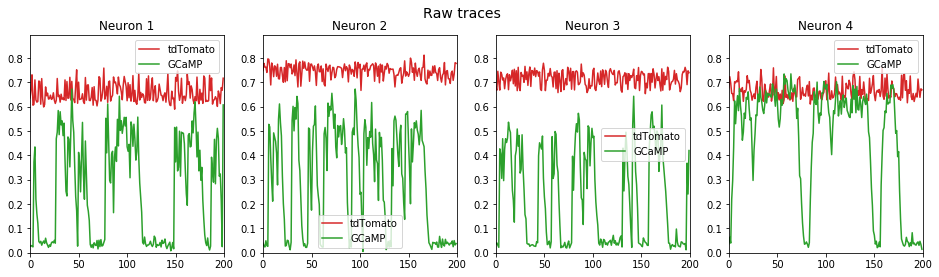

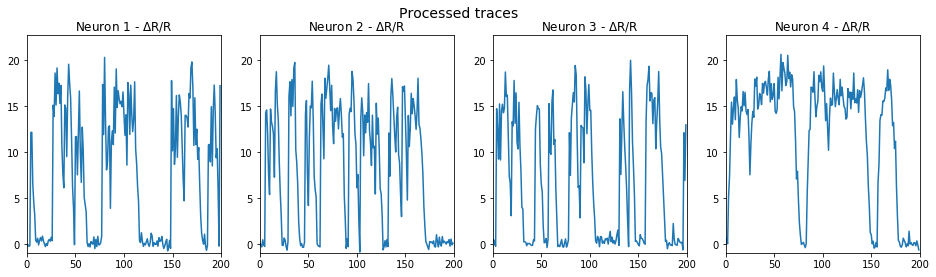

In [55]:
n_frames_0 = 10 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 10:
    print(identities.max(), "different neurons identified, traces are not computed.")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(rgb_stack[...,0][np.logical_not(seg_stack)])
# bkg_g = np.mean(rgb_stack[...,1][np.logical_not(seg_stack)])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        roi = rgb_stack[i,...][identities[i] == (j + 1)]
        if roi.size > 0:
            traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= 1.1 * bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < 1.1 * bkg: {:.3f} < {:.3f}). "
              "Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), 1.1 * bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    # If no window of n_frames_0 exists, search for smaller ones
    for j in range(1, n_frames_0):
        if not np.isinf(R_0):
            break
        R_0 = np.convolve(R_t, np.ones(n_frames_0 - j) / (n_frames_0 - j), 'valid')
        R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

reload(plt)
%matplotlib inline
N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(dR_R[has_tdTom]) + np.isinf(dR_R[has_tdTom]), 0, dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(dR_R[np.logical_not(has_tdTom)]) + np.isinf(dR_R[np.logical_not(has_tdTom)]),
                            0, dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, ymax_R if has_tdTom[i] else ymax_F)
plt.show()